<a href="https://colab.research.google.com/github/NikolValerie/homework/blob/main/09_01_demo_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фаза 2 • Неделя 2 • Понедельник
## Компьютерное зрение
### Локализация объектов

#### Подготовим импорты

Из нового:
1. `xml.etree.ElementTree` – с помощью него будем разбирать XML-файлы и доставать координаты bbox'ов
2. `torchmetrics.functional.detection.iou` – чтобы вручную не считать IoU

In [ ]:
!pip install torchutils

In [ ]:
!pip install torchmetrics

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchutils as tu
import torchvision.transforms as T
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional.detection.iou import intersection_over_union
from torchvision.models import ResNet18_Weights, resnet18

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Veg.zip to Veg.zip


In [6]:
import zipfile
import io

file_name = 'Veg.zip'

with zipfile.ZipFile(io.BytesIO(uploaded[file_name]), 'r') as zip_ref:
    zip_ref.extractall('/content')


#### XML-файлы

In [7]:
annotation = ET.parse('/content/Veg/loc_train/cucumber_1.xml')

In [8]:
print(annotation)

In [9]:
annotation.find('object').find('bndbox').find('xmin').text

'23'

#### Подгтовим датасет

Он принимает на вход в конструктор 3 переменные:
* `root_dir` – путь к обучающим/валидационным файлам (включая соответствующие xml-файлы)
* `image_size` – сразу определимся с размером картинок (у нас 227х227)
* `transform` – какие преобразования использовать для картинок (как минимум `ToTensor`, но обучающие будем аугментировать)

In [10]:
class CustomDataset(Dataset):
    def __init__(
            self,
            root_dir: str,
            image_size: int = 227,
            transform: T.Compose = None
            ):
        self.image_size = image_size
        self.root_dir = root_dir
        self.transform = transform
        # создаем два списка: с картинками и xml
        self.img_paths = sorted(glob(f'{self.root_dir}/*.jpg'))
        self.xml_paths = sorted(glob(f'{self.root_dir}/*.xml'))

        # делаем вспомогательные словари, чтобы из названий классов получать индексы
        self.cls2ix = {
            'cucumber' : 0,
            'eggplant' : 1,
            'mushroom' : 2
            }
        # и наоборот
        self.ix2cls = {v: k for k, v in self.cls2ix.items()}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # по индексу находим в списке файлов аннотацию
        annotation = ET.parse(self.xml_paths[idx])
        # забираем название файла с картинкой
        filename = annotation.find('filename').text
        # открываем картинку
        image = Image.open(os.path.join(self.root_dir, filename))
        # преобразуем
        if self.transform:
            image = self.transform(image)
        # получаем название класса
        label = annotation.find('object').find('name').text
        # преобразуем в индекс
        label = self.cls2ix[label]
        # получаем координаты настоящего бокса
        xmin = int(annotation.find('object').find('bndbox').find('xmin').text)
        ymin = int(annotation.find('object').find('bndbox').find('ymin').text)
        xmax = int(annotation.find('object').find('bndbox').find('xmax').text)
        ymax = int(annotation.find('object').find('bndbox').find('ymax').text)
        # конвертируем в тензор и масштабируем в диапазон [0-1]
        bbox = torch.Tensor((xmin, ymin, xmax, ymax)) / self.image_size
        return torch.tensor(label), bbox, image, filename

In [11]:
train_aug = T.Compose(
    [

        T.GaussianBlur(kernel_size=(5, 9), sigma=(0.3, 5.)),
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
valid_aug = T.Compose(
    [
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
train_dataset = CustomDataset(root_dir='/content/Veg/loc_train', image_size=227, transform=train_aug)
valid_dataset = CustomDataset(root_dir='/content/Veg/loc_valid', image_size=227, transform=valid_aug)

In [12]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
batch = next(iter(train_loader))
batch

[tensor([1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1,
         0, 1, 2, 1, 0, 2, 2, 1]),
 tensor([[0.1498, 0.1498, 0.3877, 0.8855],
         [0.1542, 0.1630, 0.9075, 0.6828],
         [0.0925, 0.1278, 0.8899, 0.8722],
         [0.4449, 0.2555, 0.6828, 0.5551],
         [0.1586, 0.3172, 0.9031, 0.8238],
         [0.2159, 0.1630, 0.8458, 0.7577],
         [0.2599, 0.1806, 0.9075, 0.6564],
         [0.1013, 0.2247, 0.7841, 0.9471],
         [0.1057, 0.2687, 0.8634, 0.8150],
         [0.0837, 0.2159, 0.9251, 0.7445],
         [0.2423, 0.1322, 0.7357, 0.9339],
         [0.2907, 0.1410, 0.7225, 0.8855],
         [0.0485, 0.1366, 0.9559, 0.9163],
         [0.0308, 0.1101, 0.9251, 0.9780],
         [0.0749, 0.1322, 0.9339, 0.8194],
         [0.3436, 0.0749, 0.6740, 0.9559],
         [0.0617, 0.4273, 0.9427, 0.8106],
         [0.0573, 0.3084, 0.9648, 0.7048],
         [0.2467, 0.1542, 0.6388, 0.9339],
         [0.1145, 0.0969, 0.8855, 0.7577],
         [0.1410, 0.1894

# Модель

В качестве экстрактора признаков будем использовать предобученный ResNet18, но отрежем последние два слоя: пулинг и полносвязный

In [14]:
feature_extractor = resnet18(weights=ResNet18_Weights.DEFAULT)
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.1MB/s]


In [15]:
feature_extractor(torch.randn(BATCH_SIZE, 3, 227, 227)).shape

torch.Size([32, 512, 8, 8])

Задаем класс модели в соответствии со схемой:
<img src="../slides/sources/aux/localization_model.png">

In [16]:
class LocModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
        # фризим слои, обучать их не будем (хотя технически можно)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # классификационный блок
        self.clf = nn.Sequential(
            nn.Linear(512*8*8, 128),
            nn.Sigmoid(),
            nn.Linear(128, 3)
        )

        # регрессионный блок
        self.box = nn.Sequential(
            nn.Linear(512*8*8, 128),
            nn.Sigmoid(),
            nn.Linear(128, 4),
            nn.Sigmoid()
        )

    def forward(self, img):
        # задаём прямой проход
        resnet_out = self.feature_extractor(img)
        resnet_out = resnet_out.view(resnet_out.size(0), -1)
        logits = self.clf(resnet_out)   # предсказанные классы
        box_coords = self.box(resnet_out)  # предсказанные координаты
        print(logits.shape, box_coords.shape)
        return logits, box_coords

In [18]:
!pip install torchinfo

In [19]:
model = LocModel()
# проверь модель на батче: помни, что он возвращает tuple, оттуда нужно не всё
#tu.get_model_summary(...)
import torchinfo

device = torch.device('cpu')
batch = batch[2].to(device)  # только картинки из батча

model.to(device)
model.eval()
with torch.no_grad():
    output = model(batch)

torchinfo.summary(model, input_data=batch)  # проверяем модель на батче

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])


Layer (type:depth-idx)                        Output Shape              Param #
LocModel                                      [32, 3]                   --
├─Sequential: 1-1                             [32, 512, 8, 8]           --
│    └─Conv2d: 2-1                            [32, 64, 114, 114]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 114, 114]        (128)
│    └─ReLU: 2-3                              [32, 64, 114, 114]        --
│    └─MaxPool2d: 2-4                         [32, 64, 57, 57]          --
│    └─Sequential: 2-5                        [32, 64, 57, 57]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 57, 57]          (73,984)
│    │    └─BasicBlock: 3-2                   [32, 64, 57, 57]          (73,984)
│    └─Sequential: 2-6                        [32, 128, 29, 29]         --
│    │    └─BasicBlock: 3-3                   [32, 128, 29, 29]         (230,144)
│    │    └─BasicBlock: 3-4                   [32, 128, 29, 29]     

#### Обучение

In [20]:
# этот блок можно оставить, а можно изменить и посмотреть на результат
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=.9)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25])

In [21]:
# создаем словарь для логов, 10 ключей (см. слайды)
log = dict()
log['epoch_train_clf_loss'] = []
log['epoch_valid_clf_loss'] = []
log['epoch_train_reg_loss'] = []
log['epoch_valid_reg_loss'] = []
log['epoch_train_total_loss'] = []
log['epoch_valid_total_loss'] = []
log['epoch_train_accuracy'] = []
log['epoch_valid_accuracy'] = []
log['epoch_train_iou'] = []
log['epoch_valid_iou'] = []

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 000
Train stage: clf_loss: 0.497 reg_loss: 0.540 total_loss: 1.036 train_accuracy: 0.965 train_iou: 0.623
Valid stage: clf_loss: 0.585 reg_loss: 0.331 total_loss: 0.917 valid_accuracy: 0.953 valid_iou: 0.626


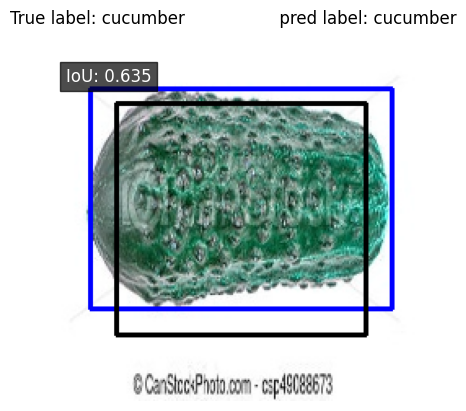

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 001
Train stage: clf_loss: 0.435 reg_loss: 0.508 total_loss: 0.943 train_accuracy: 0.981 train_iou: 0.632
Valid stage: clf_loss: 0.638 reg_loss: 0.335 total_loss: 0.973 valid_accuracy: 0.760 valid_iou: 0.626


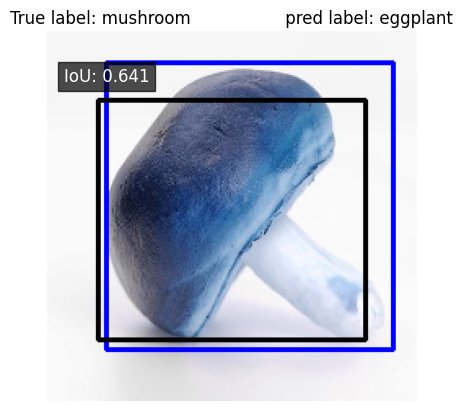

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 002
Train stage: clf_loss: 0.413 reg_loss: 0.527 total_loss: 0.940 train_accuracy: 0.975 train_iou: 0.634
Valid stage: clf_loss: 0.881 reg_loss: 0.323 total_loss: 1.204 valid_accuracy: 0.448 valid_iou: 0.634


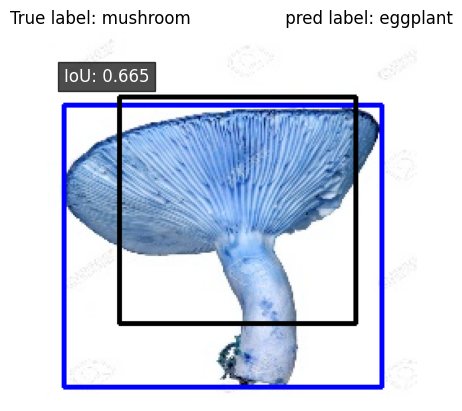

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 003
Train stage: clf_loss: 0.452 reg_loss: 0.527 total_loss: 0.979 train_accuracy: 0.927 train_iou: 0.628
Valid stage: clf_loss: 0.486 reg_loss: 0.307 total_loss: 0.793 valid_accuracy: 0.969 valid_iou: 0.599


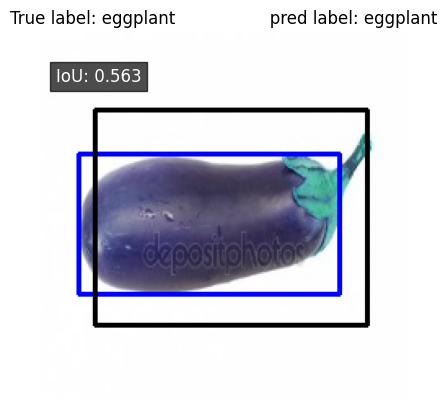

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 004
Train stage: clf_loss: 0.377 reg_loss: 0.493 total_loss: 0.870 train_accuracy: 1.000 train_iou: 0.640
Valid stage: clf_loss: 0.546 reg_loss: 0.340 total_loss: 0.886 valid_accuracy: 0.984 valid_iou: 0.624


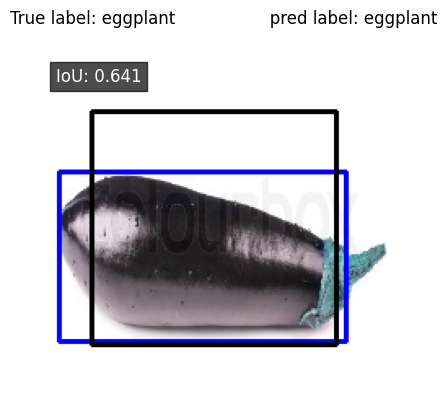

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 005
Train stage: clf_loss: 0.452 reg_loss: 0.454 total_loss: 0.906 train_accuracy: 0.927 train_iou: 0.651
Valid stage: clf_loss: 0.956 reg_loss: 0.424 total_loss: 1.380 valid_accuracy: 0.729 valid_iou: 0.567


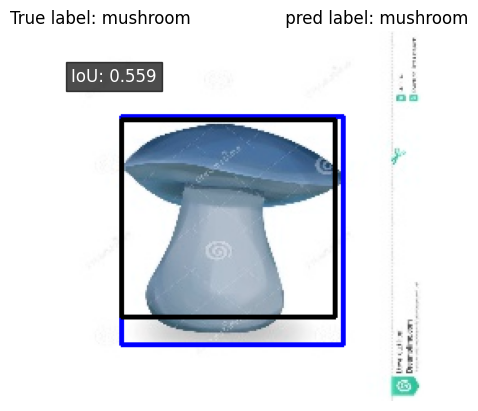

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 006
Train stage: clf_loss: 0.674 reg_loss: 0.554 total_loss: 1.229 train_accuracy: 0.811 train_iou: 0.620
Valid stage: clf_loss: 0.744 reg_loss: 0.323 total_loss: 1.066 valid_accuracy: 0.693 valid_iou: 0.614


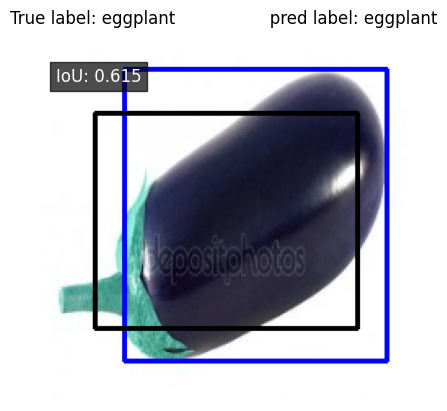

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 007
Train stage: clf_loss: 0.580 reg_loss: 0.535 total_loss: 1.115 train_accuracy: 0.938 train_iou: 0.631
Valid stage: clf_loss: 0.727 reg_loss: 0.343 total_loss: 1.071 valid_accuracy: 0.802 valid_iou: 0.633


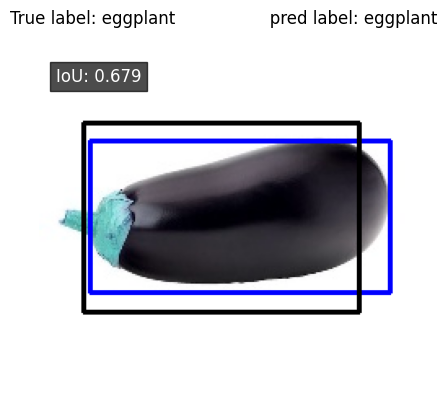

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 008
Train stage: clf_loss: 0.662 reg_loss: 0.517 total_loss: 1.179 train_accuracy: 0.819 train_iou: 0.628
Valid stage: clf_loss: 0.720 reg_loss: 0.333 total_loss: 1.052 valid_accuracy: 0.984 valid_iou: 0.600


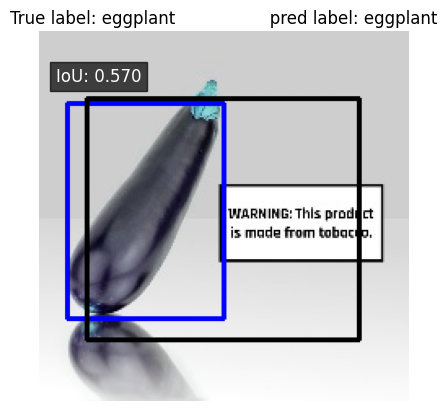

torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


torch.Size([6, 3]) torch.Size([6, 4])
Epoch 009
Train stage: clf_loss: 0.609 reg_loss: 0.532 total_loss: 1.141 train_accuracy: 1.000 train_iou: 0.633
Valid stage: clf_loss: 0.797 reg_loss: 0.329 total_loss: 1.126 valid_accuracy: 0.547 valid_iou: 0.634


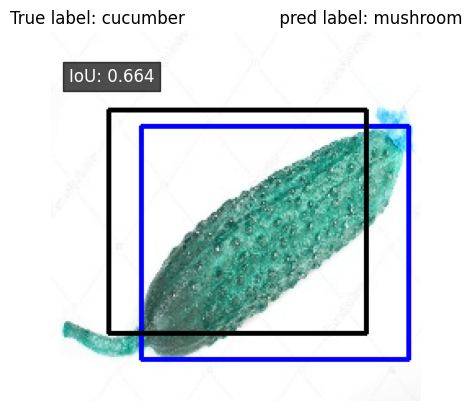

In [31]:
for i in range(10):
    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []

    ####### обучающий шаг
    model.train()
    for true_label, true_box, image, filename  in train_loader:
        logits, coords = model(image)
        loss_clf = F.cross_entropy(logits, torch.Tensor(true_label))
        loss_coords = F.huber_loss(coords, true_box, reduction='sum', delta=.5)
        total_loss = loss_clf + loss_coords
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        iou = intersection_over_union(coords, true_box)
        accuracy = (logits.argmax(1) == true_label).sum()/true_label.size(0)

        batch_acc.append(accuracy.item())
        batch_iou.append(iou.item())

        batch_reg_loss.append(loss_coords.item())
        batch_clf_loss.append(loss_clf.item())
        batch_total_loss.append(total_loss.item())

    log['epoch_train_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_train_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_train_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_train_accuracy'].append(np.mean(batch_acc))
    log['epoch_train_iou'].append(np.mean(batch_iou))

    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []
    ######### валидационный шаг
    model.eval()
    for true_label, true_box, image, filename  in valid_loader:
        with torch.no_grad():
            logits, coords = model(image)
        loss_clf = F.cross_entropy(logits, torch.Tensor(true_label))
        loss_coords = F.huber_loss(coords, true_box, reduction='sum', delta=.2)
        total_loss = loss_clf + loss_coords

        iou = intersection_over_union(coords, true_box)
        accuracy = (logits.argmax(1) == true_label).sum()/true_label.size(0)

        batch_acc.append(accuracy.item())
        batch_iou.append(iou.item())

        batch_reg_loss.append(loss_coords.item())
        batch_clf_loss.append(loss_clf.item())
        batch_total_loss.append(total_loss.item())

    log['epoch_valid_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_valid_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_valid_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_valid_accuracy'].append(np.mean(batch_acc))
    log['epoch_valid_iou'].append(np.mean(batch_iou))

    print(f'Epoch {i:0>3}')
    print(f"Train stage: clf_loss: {log['epoch_train_clf_loss'][-1]:.3f} reg_loss: {log['epoch_train_reg_loss'][-1]:.3f} total_loss: {log['epoch_train_total_loss'][-1]:.3f} train_accuracy: {log['epoch_train_accuracy'][-1]:.3f} train_iou: {log['epoch_train_iou'][-1]:.3f}")

    print(f"Valid stage: clf_loss: {log['epoch_valid_clf_loss'][-1]:.3f} reg_loss: {log['epoch_valid_reg_loss'][-1]:.3f} total_loss: {log['epoch_valid_total_loss'][-1]:.3f} valid_accuracy: {log['epoch_valid_accuracy'][-1]:.3f} valid_iou: {log['epoch_valid_iou'][-1]:.3f}")

    if not i % 1:
        fig, ax = plt.subplots(1, 1, squeeze=True)
        rnd_index = logits.size(0)-1
        img = image[rnd_index].permute(1, 2, 0).numpy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_box = cv2.rectangle(
            img,
            (true_box[rnd_index][:2].numpy()*train_dataset.image_size).astype('int'),
            (true_box[rnd_index][2:].numpy()*train_dataset.image_size).astype('int'),
            color=(0,0,255), thickness=2
        )

        pred_box = cv2.rectangle(
            img,
            (coords[rnd_index][:2].numpy()*train_dataset.image_size).astype('int'),
            (coords[rnd_index][2:].numpy()*train_dataset.image_size).astype('int'),
            color=(0,0,0), thickness=2
        )
    ax.imshow(true_box)
    ax.imshow(pred_box)
    ax.set_axis_off()
    text = f"IoU: {iou.item():.3f}"
    ax.text(10, 30, text, color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.7))
    plt.title(f'True label: {train_dataset.ix2cls[true_label[rnd_index].item()]}\
                  pred label: {train_dataset.ix2cls[logits[rnd_index].argmax().item()]}')
    plt.show()

Визуализируй лоссы и метрики обучени на с помощью кривых обучения

In [ ]:
...